In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
pv.set_jupyter_backend('client')
import glob
import natsort

In [36]:
data_path = '/home/dana/Documents/SimVascular/svMultiPhysics/NoisyPipe/NP_0042_bent/'
# data_path = '/home/dana/Documents/SimVascular/svMultiPhysics/NoisyPipe/pipe_RCR_3d/'
pref = '4-procs/result'
filepath = data_path + pref + '_100.vtu'
mesh = pv.read(filepath)

half_pipe = mesh.clip(normal='y',origin=mesh.center,invert=False)
wall = mesh.extract_surface()
boundary = mesh.decimate_boundary().extract_all_edges()

# Define streamlines source
fluid = pv.read(data_path+'geom/fluid.vtp') # Load fluid geometry
markers = fluid.cell_data["marker"]
mask = markers == 0
cell_ids = np.where(mask)[0]
inlet = fluid.extract_cells(cell_ids) # Extract inlet face
source_center = inlet.points.mean(axis=0) # Centroid of inlet
vecs = np.random.normal(size=(100, 3))
vecs /= np.linalg.norm(vecs, axis=1)[:, None]   # normalize
radii = 0.8 * np.random.rand(100) ** (1/3)  # scale radius correctly
seed_source = source_center + vecs * radii[:, None]
seed_source = pv.PolyData(seed_source)
# enclosure = fluid.select_enclosed_points(seed_source, tolerance=1e-6)
# mask = enclosure.point_data['SelectedPoints'].astype(bool)
# source = seed_source.extract_points(mask)
source = seed_source

mesh.set_active_vectors('Velocity')
mesh.set_active_scalars('Velocity')
streamlines = mesh.streamlines_from_source(source, vectors="Velocity",integration_direction='forward')

plotter = pv.Plotter(notebook=True)  # Use notebook=False outside Jupyter
# plotter.add_mesh(mesh, style="wireframe")
plotter.add_mesh(mesh, 
    scalars="WSS", 
    cmap="viridis",
    # edge_color='black',
    # show_edges=True,
    # edge_opacity=0.3,
    # clim=[0,100],
    # opacity=0.3
    )
# plotter.add_mesh(boundary,opacity=0.3)
# plotter.add_mesh(streamlines.tube(radius=0.01),cmap='viridis')
# plotter.add_points(np.array(source_center),color='red')
# plotter.add_points(source,color='red', point_size=10)

# plotter.add_scalar_bar(title="Pressure")
plotter.camera_position = 'xz'
plotter.add_axes(interactive=True)

plotter.show()


Widget(value='<iframe src="http://localhost:41289/index.html?ui=P_0x778ece6ef140_27&reconnect=auto" class="pyv…

Text(0, 0.5, 'Velocity Flux at Outlet')

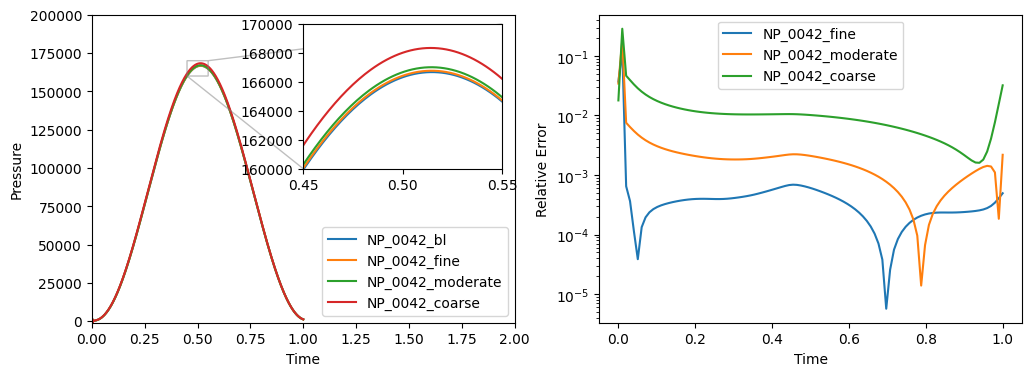

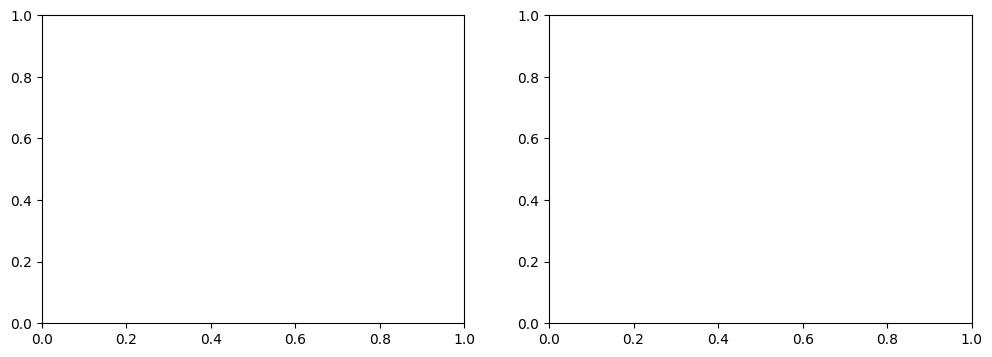

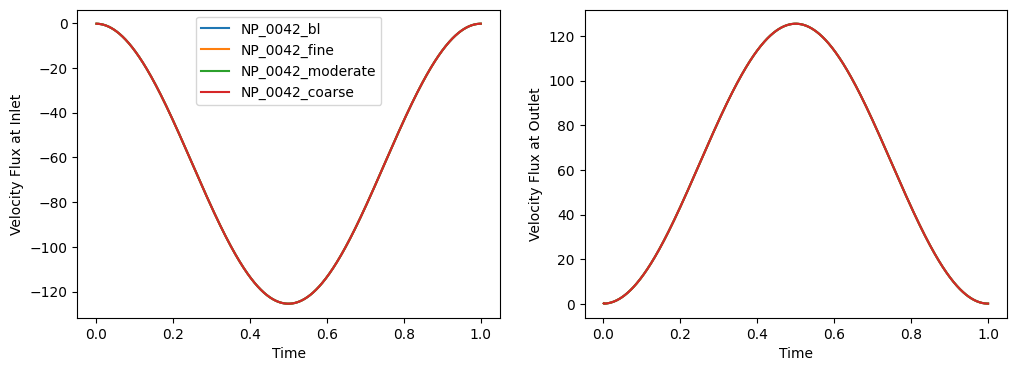

In [44]:
# Compare cases
# cases = ['NP_0000_fine','NP_0000','NP_0000_coarse']
# cases = ['NP_0000_sten_bl','NP_0000_sten_nobl']
cases = ['NP_0042_bl','NP_0042_fine','NP_0042_moderate','NP_0042_coarse']

# Pressure on wall
fig,ax=plt.subplots(1,2,figsize=(12,4))
axins = ax[0].inset_axes([0.5, 0.5, 0.47, 0.47])
data_list = []
time = np.linspace(0,1,100)
for case in cases:
    data_path = '/home/dana/Documents/SimVascular/svMultiPhysics/NoisyPipe/' + case + '/'
    data = np.loadtxt(data_path + '4-procs/B_NS_Pressure_average.txt',skiprows=10)
    data_list.append(np.interp(time,data[:,1],data[:,4]))
    ax[0].plot(data[:,1],data[:,4],label=case)

    # Plot inset zoomed in at peak
    axins.plot(data[:,1],data[:,4],label=case)
    axins.set_xlim(0.45,0.55)
    axins.set_ylim(160000,170000)
    # axins.set_xlim(0.,0.1)
    # axins.set_ylim(0,1000)
    # axins.set_xticks([0.45,0.5,0.55])
    # axins.set_yticks([160000,170000])
ax[0].set_xlim(0,2)
ax[0].set_ylim(-1000,200000)
ax[0].indicate_inset_zoom(axins)
ax[0].legend(loc='lower right')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Pressure')

# Error relative to finest
for i, data in enumerate(data_list):
    if i == 0:
        continue
    ax[1].semilogy(time,np.abs((data_list[0]-data)/data_list[0]),label=cases[i])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Relative Error')
ax[1].legend(loc='best')

# WSS
fig,ax=plt.subplots(1,2,figsize=(12,4))
for case in cases:
    data_path = '/home/dana/Documents/SimVascular/svMultiPhysics/NoisyPipe/' + case + '/'
    pref = '4-procs/result'
    for i in range(25,250,25):
        frame = str(i).zfill(3)
        filepath = data_path + pref + '_' + frame + '.vtu'
        mesh = pv.read(filepath)
        surf = mesh.extract_surface()


# Velocity fluxes
fig,ax=plt.subplots(1,2,figsize=(12,4))
for case in cases:
    data_path = '/home/dana/Documents/SimVascular/svMultiPhysics/NoisyPipe/' + case + '/'
    data = np.loadtxt(data_path + '4-procs/B_NS_Velocity_flux.txt',skiprows=10)
    ax[0].plot(data[:,1],data[:,2],label=case)
    ax[1].plot(data[:,1],data[:,3],label=case)
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Velocity Flux at Inlet')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity Flux at Outlet')